## Imports

In [1]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

In [2]:
path = kagglehub.dataset_download("sidharkal/sports-image-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ahmed\.cache\kagglehub\datasets\sidharkal\sports-image-classification\versions\1


In [3]:
data_dir = "../data"
images_dir = "../data/dataset/"
train_dir = images_dir + "train/"

badminton_train_dir = train_dir + "Badminton/"
tennis_train_dir = train_dir + "Tennis/"
cricket_train_dir = train_dir + "Cricket/"
soccer_train_dir = train_dir + "Soccer/"
swimming_train_dir = train_dir + "Swimming/"
karate_train_dir = train_dir + "Karate/"
wrestling_train_dir = train_dir + "Wrestling/"

test_dir = images_dir + "test/"

badminton_test_dir = test_dir + "Badminton/"
tennis_test_dir = test_dir + "Tennis/"
cricket_test_dir = test_dir + "Cricket/"
soccer_test_dir = test_dir + "Soccer/"
swimming_test_dir = test_dir + "Swimming/"
karate_test_dir = test_dir + "Karate/"
wrestling_test_dir = test_dir + "Wrestling/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(42)

In [5]:
shutil.copytree(path, data_dir, dirs_exist_ok=True)

'../data'

## Organizing Data structure

In [6]:
# checking the train.csv , test.csv
train_df = pd.read_csv(images_dir +"/train.csv")
test_df = pd.read_csv(images_dir +"/test.csv")

In [7]:
test_df

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg
...,...
2051,7be6c552a7.jpg
2052,4c9427f2a5.jpg
2053,0f429ae0d4.jpg
2054,a6557bedd9.jpg


In [8]:
train_df

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


In [9]:
train_df.set_index("image_ID", inplace=True), test_df.set_index("image_ID", inplace=True)

(None, None)

### Moving data to be per label

In [10]:
labels = train_df["label"].unique()

for label in labels:
    os.makedirs(train_dir + label, exist_ok=True)
    os.makedirs(test_dir + label, exist_ok=True)

In [11]:
labels

array(['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer',
       'Wrestling', 'Karate'], dtype=object)

In [12]:
train_df.loc['7c225f7b61.jpg']['label']

'Badminton'

In [13]:
print(train_dir)

../data/dataset/train/


In [14]:
for i in range(len(train_df)):
    image_id = train_df.index[i]
    label = train_df['label'][i]
    old_path = train_dir + image_id
    new_path = train_dir + label + "/" + image_id
    if os.path.exists(old_path):
        shutil.move(old_path, new_path)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_23384\728234997.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = train_df['label'][i]


### Labeling Test data as it was unlabeled

In [15]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

def classify_with_clip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1)
    pred = probs.argmax()
    return classes[pred]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [16]:
for i in tqdm(range(len(test_df))):
    image_id = test_df.index[i]
    image_path = test_dir + image_id
    if not os.path.exists(image_path):
        continue
    label = classify_with_clip(image_path)
    test_df.at[image_id, 'label'] = label
    new_path = test_dir + label + "/" + image_id
    if os.path.exists(image_path):
        shutil.move(image_path, new_path)


100%|██████████| 2056/2056 [01:39<00:00, 20.68it/s]


## Statistics from the data

### Checking distribution of classes

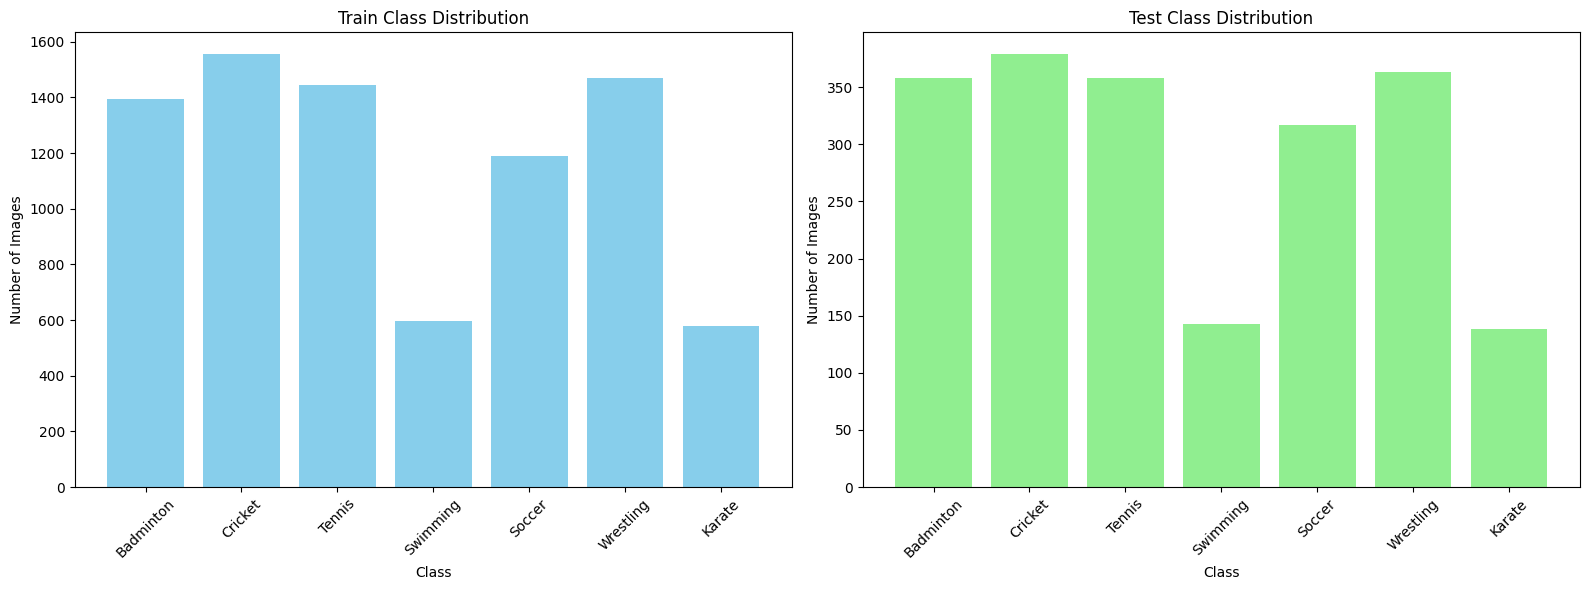

In [ ]:

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

train_dirs = [train_dir + cls + "/" for cls in classes]
test_dirs = [test_dir + cls + "/" for cls in classes]

train_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in train_dirs]
test_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in test_dirs]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(classes, train_counts, color='skyblue')
axs[0].set_title('Train Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Images')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(classes, test_counts, color='lightgreen')
axs[1].set_title('Test Class Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Images')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Per class statistics

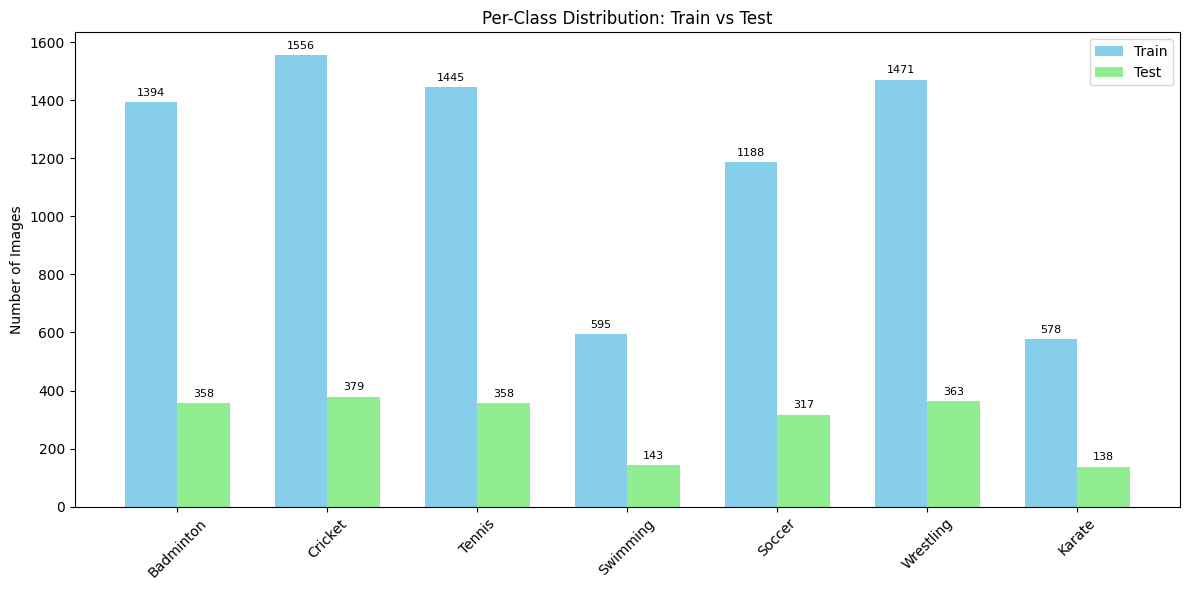

In [ ]:
x = np.arange(len(classes))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color='lightgreen')

ax.set_ylabel('Number of Images')
ax.set_title('Per-Class Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()

### Pixel Value Distribution

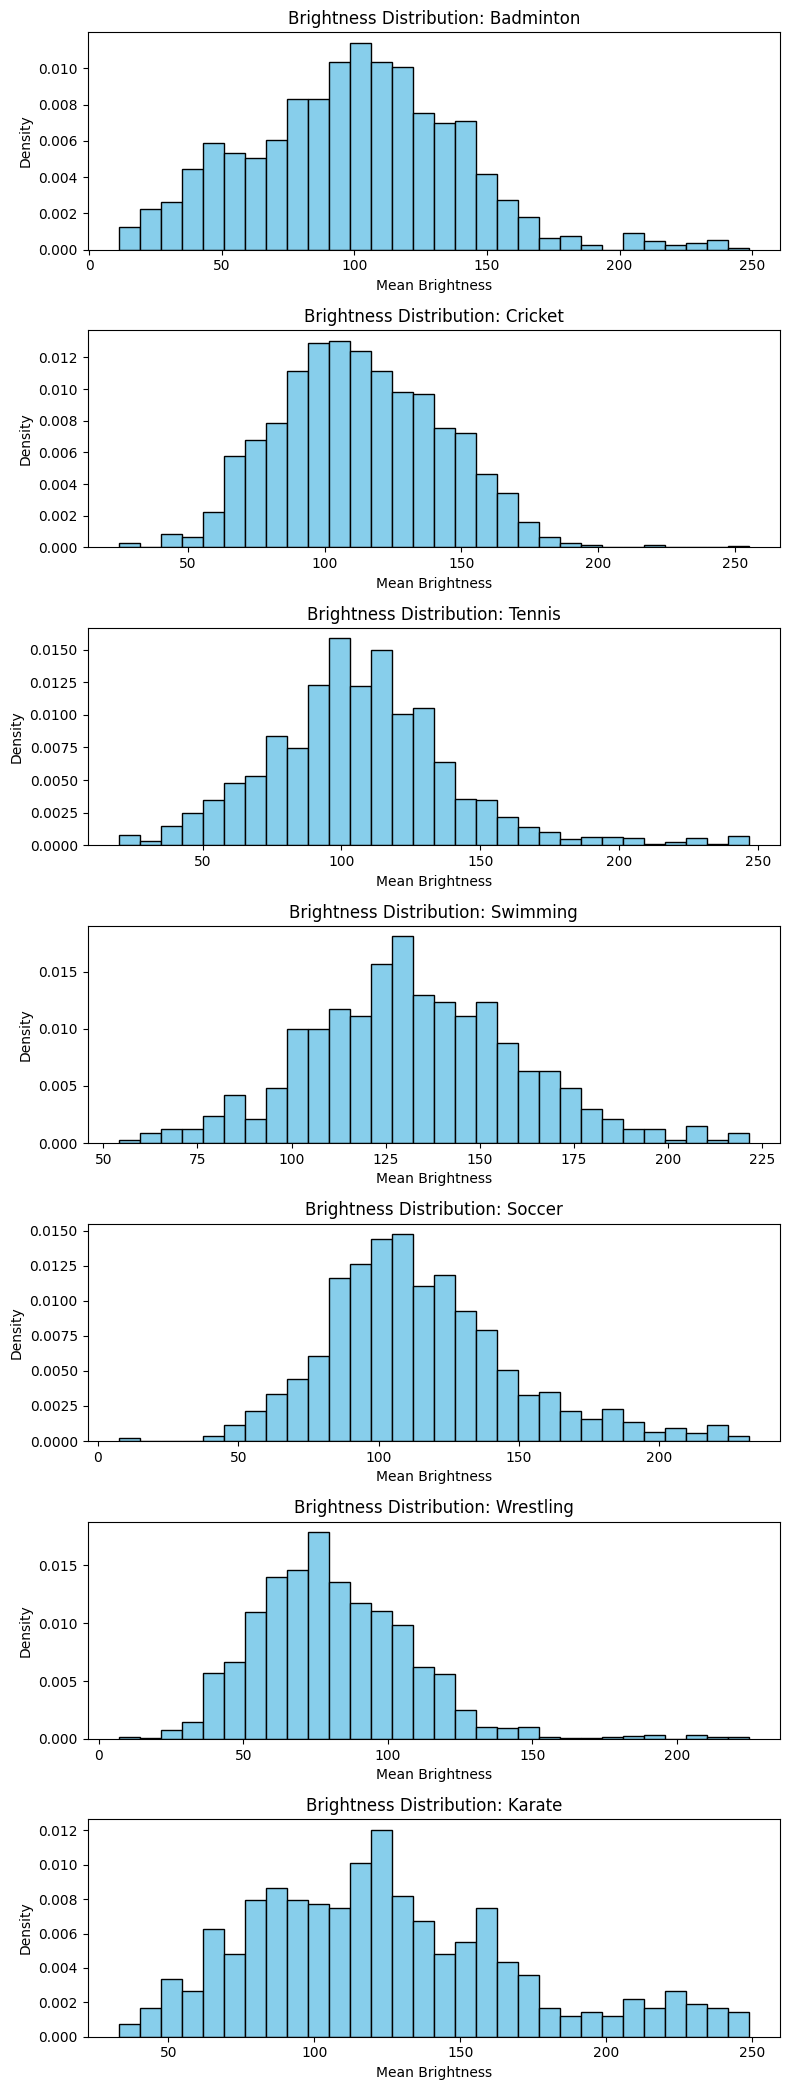

In [ ]:
class_brightness = {cls: [] for cls in classes}

for cls, folder in zip(classes, train_dirs):
    if not os.path.exists(folder):
        continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        try:
            img = Image.open(img_path).convert("L")  
            img_arr = np.array(img)
            mean_brightness = img_arr.mean()
            class_brightness[cls].append(mean_brightness)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Plot distributions
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*3))

for idx, cls in enumerate(tqdm(classes)):
    axs[idx].hist(class_brightness[cls], bins=30, color='skyblue', edgecolor='black', density=True)
    axs[idx].set_title(f'Pixel Distribution: {cls}')
    axs[idx].set_xlabel('Mean Pixel Values')
    axs[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

- Pixels values are distributed well across all the images meaning that the images are not too dark or too bright.
- Thus images is considered to be well exposed and not too dark or too bright so little noise are added.

## Showing some images per class

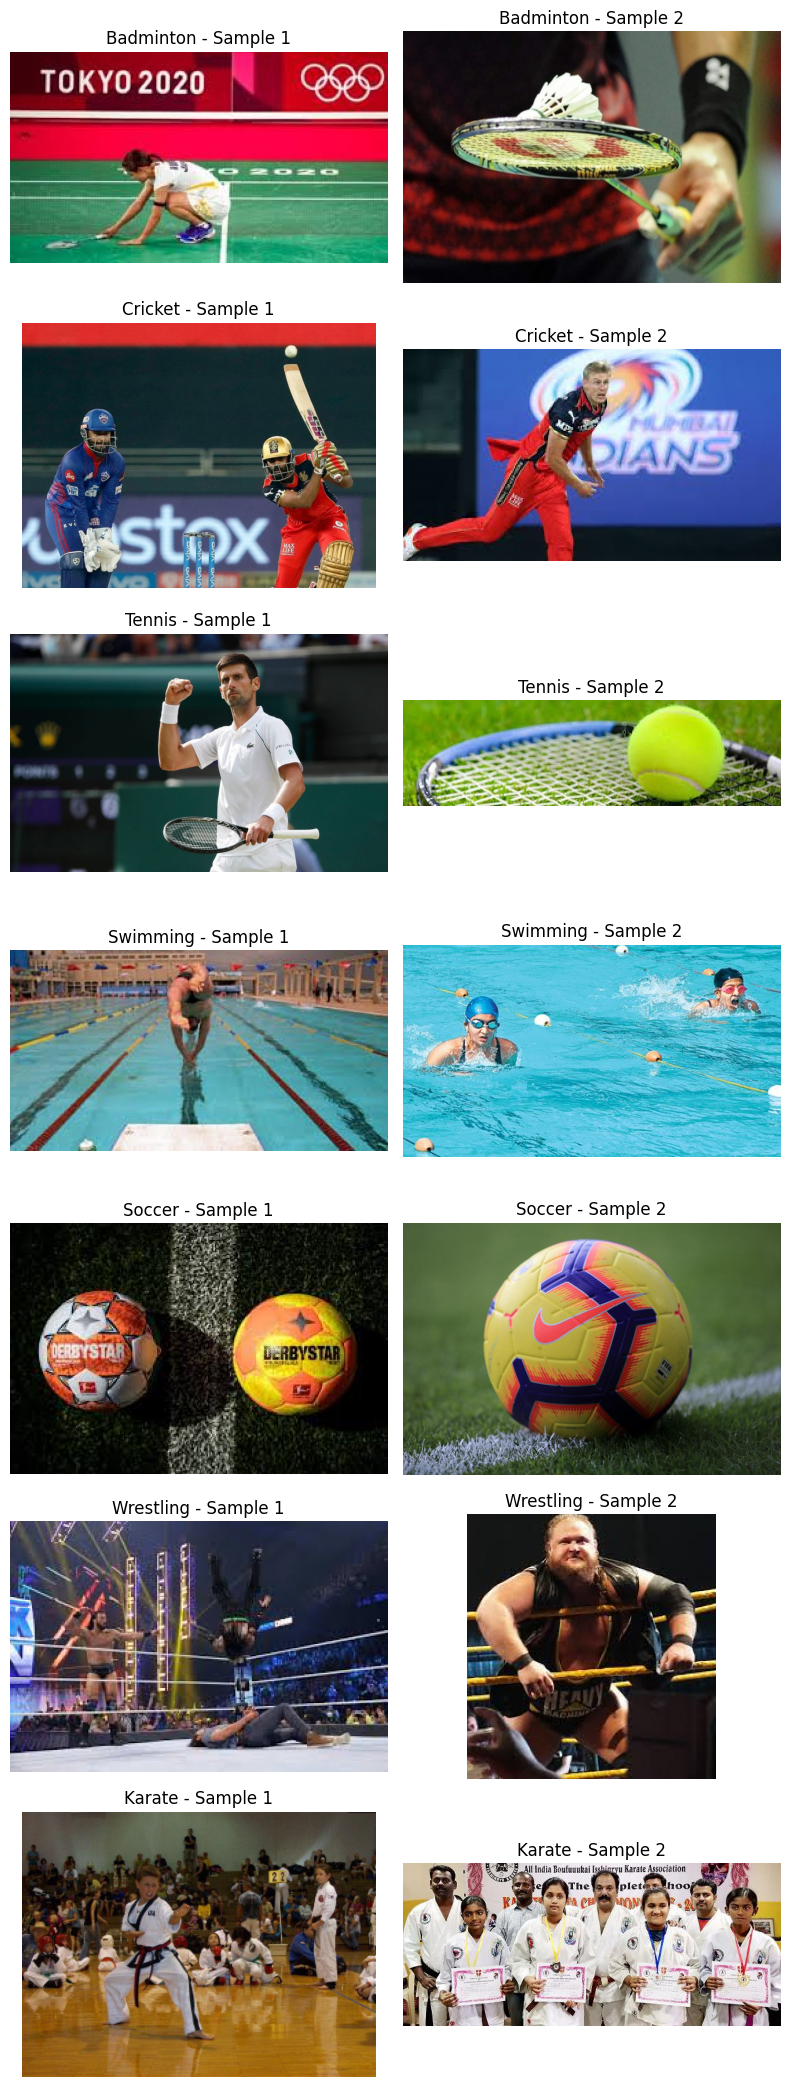

In [22]:
fig, axs = plt.subplots(len(classes), 2, figsize=(8, len(classes) * 3))

for row_idx, (cls, folder) in enumerate(zip(classes, train_dirs)):
    if not os.path.exists(folder):
        continue
    images = [f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected_images = images[:2]  
    for col_idx in range(2):
        if col_idx < len(selected_images):
            img_path = os.path.join(folder, selected_images[col_idx])
            img = Image.open(img_path)
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            if col_idx == 0:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 1")
            else:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 2")
        else:
            axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

## Dataset class and data manager

### Dataset class

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        """
        Args:
            root_dir (str): Directory with all the class folders.
            classes (list): List of class names (subfolder names).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.samples = []

        for idx, cls in enumerate(classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, idx))  # (image_path, class_idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

In [11]:
train_dir

'../data/dataset/train/'

In [ ]:
train_dataset = ImageDataset(root_dir=train_dir, classes=classes,)
test_dataset = ImageDataset(root_dir=test_dir, classes=classes,)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)